# Getting Hands-On with Linear Learner and Amazon SageMaker

# Assumptions and Disclaimers
This blogpost assumes that you have already completed the following tutorials from Amazon SageMaker docuemntation:
- [Setting up](https://docs.aws.amazon.com/sagemaker/latest/dg/gs-set-up.html)
- [Create am Amazon SageMaker Notebook Instance](https://docs.aws.amazon.com/sagemaker/latest/dg/gs-setup-working-env.html)
- I have included 'sagemaker' in the name of my S3 bucket, "cyrusmv-sagemaker-demos' and have chosen to let any SageMaker notebook instance to access any S3 bucket with the term 'sagemaker' included in the name. This is however is not a recommended security option for production and is only useful for simplifying the flow of the blog.
- I have downloaded [Visa dataset from Kaggle](https://www.kaggle.com/dalpozz/creditcardfraud), have renamed it to original.csv, and have uploaded it to a S3 bucket. You would need to do the same.
- It is assumed that the reader is familiar with linear regression. If not please read part 1 of this post.



# Introduction

In this part of the blog, I will provide an introduction to inner-workings of SageMaker and Amazon LinearLearner algorithm. Then I will download [Visa dataset from Kaggle](https://www.kaggle.com/dalpozz/creditcardfraud) from an S3 location to my notebook instanceand pre-process it in order to feed the data to the algorithm.
We then create a live endpoint and make predictions using trained models.

Amazon SageMaker
Amazon SageMaker is a fully managed machine learning service that automates the end-to-end ML process. With Amazon SageMaker, data scientists and developers can quickly and easily build and train machine learning models and directly deploy them into a production-ready hosted environment. It provides an integrated Jupyter authoring notebook instance for easy access to your data sources for exploration and analysis, so you don't have to manage servers. It also provides common machine learning algorithms that are optimized to run efficiently against extremely large data in a distributed environment. With native support for bring-your-own-algorithms and frameworks, Amazon SageMaker offers flexible distributed training options that adjust to your specific workflows. Deploy a model into a secure and scalable environment by launching it with a single click from the Amazon SageMaker console. Training and hosting are billed by minutes of usage, with no minimum fees and no upfront commitments.
SageMaker python sdk, is a library that provides the user with the ability to wrap your models in helper classes that can be passed to Amazon SageMaker. The python sdk provides you with the ability to use Amazon Algorithms, train and deploy your own code (currently MXNet and TensorFlow) using Amazon SagedMaker, and bring your own pre-trained dockerized models.
Let us next take a look at the architecture of SageMaker.
How does Amazon SageMaker Work:
Training
Training workloads, for an end-to-end model development includes the following components:
•	S3 Bucket for the training dataset
•	Amazon SageMaker notebook instance, a fully managed single tenant EC2 instance.
•	EC2 cluster for training. (fully managed transparent to developer)
•	S3 bucket for trained model
Hosting
•	S3 bucket for model
•	ECS infrastructure to host a dockerized model (fully managed transparent to developer)
•	EC2 cluster manages by ECS
•	Model Endpoints, elastically scalable callable inference endpoints. (fully managed transparent to developer)


![SageMaker Architecture](https://docs.aws.amazon.com/sagemaker/latest/dg/images/ironman-architecture.png)

## The SageMaker Process - Training
1. Upload the data into S3. Prior to this we go through several preparation steps that are necessary, but are not specific to Amazon SageMaker. 
2. Train: Training code is wrapped inside sagemaker helper code. In case of Amazon Algorithms this is already completed and instead of using your own training and wrapper code, you can simply pull the model from [Amazon ECR (Elastic Container Registry)](https://aws.amazon.com/ecr/). During the training process, the following steps will happen:
 1. A training cluster based on requested specification will be created. 
 Dataset will be streamed to the training cluster
    - Authentication and Authorization will be based on execution role of the SageMaker 
 2. A training job is launched.
 3. Data is streamed to the training instances.
 4- Hyperparameters are passed to the training model.
 5- Training will end after a termination criteria is reached.
2. After the model is trained, model artefacts will be uploaded to S3.
3. The training cluster is torn down.


### Get the data
1. Download the dataset from [kaggle](https://www.kaggle.com/dalpozz/creditcardfraud) to your local machine.
2. Upload the dataset onto S3. *reminder*: I am using an S3 bucket whose name includes the term *"sagemaker"*
The rest of this blog assumes that you have already done this.
### Inspecting and understanding the data 
*NOTE:* If you are interested in learning about preprocessing data, you should start here, otherwise you could simply start from part 2, the SageMaker Pipeline, when we load the data from npy files.
1. Download the dataset from S3 onto your notebook instance
2. Loading the csv file into a pandas dataframe for inspection

In [29]:
#imports
import boto3 #AWS python SDK for accessing AWS services
import pandas as pd #Tabular data structure
import numpy as np #Array libraru with probability and statistics capabilities
import matplotlib.pyplot as plt # Plotting library
import seaborn as sns #plotting library
import io
import sagemaker.amazon.common as smac # Amazon Sagemaker common library that includes data formats
import sagemaker #sagemaker python sdk
import os
from sagemaker.predictor import csv_serializer, json_deserializer #sagemaker prediction sdk

In [30]:
bucket = 'cyrusmv-sagemaker-demos'     #replace this with your own bucket 
prefix = 'visa-kaggle/original.csv'    #replace this with your own file inside the bucket
protocol="s3://"
datafile = 'data/original.csv'
local_pickel_root = 'data/processed/visa-kaggle/data/'
dist = 'visa-kaggle/data/'
 
# Define IAM role
#import boto3
#import re
from sagemaker import get_execution_role
role = get_execution_role() #this is SageMaker role that would be later used for authorizing SageMaker to access S3
print(role) 

sagemaker_session = sagemaker.Session()

arn:aws:iam::475933981307:role/service-role/AmazonSageMaker-ExecutionRole-20180102T172706


### Pre-Processing
pre-processing included several steps
1. Downloding file locally
2. Loading file into pandas for inspection
3. conversing pandas DataFrame to numpy
4. shuffling the data
5. spliting data into test and training
6. breaking up each data set to data and label

In [33]:
#Downloading the file to a local folder
client = boto3.client('s3')
with open(datafile, 'wb') as f:
    client.download_fileobj(bucket, prefix, f)

In [34]:
# loading data into pandas for inspection
df = pd.read_csv(datafile)
print(df.as_matrix().shape)

(284807, 31)


### Data Dimension
Shape of data is $284807 \times 31$, meaning that $dim(input\_data)\ = \ 1$. Next we would like to distinguish features from the target.

In [35]:
df.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [36]:
# We would like to see what values we have for "Class". This snippet below shows that Class is a binary column.
print()
print(df.groupby('Class').size())


Class
0    284315
1       492
dtype: int64


### Feature and Target identification
*"Class"* is our target and the rest of the columns are our features. Next we would like to understand values or clusters of *"Class"*.

This tells us that we are predicting a binary target and this instead of linear regression, would should be performing a logistic regression or binary classification.

So far we know that:
- Of the 31 input dimentions, 30 are features and *'Class'* is the target.
- The target is a binary prediction
thus our lineare regression function would be defined as:

$$
f:\mathbb{R}^{30} \rightarrow \{0, 1\} \\
f(x) = W_{30 \times 1} V_{1 \times 30} + b
$$

In [37]:
num_recs = df['Class'].count()
num_zeros = df['Class'][df['Class']==0].count()
num_ones = num_recs - num_zeros
print("{}% of transactions are fraudunat and {}% are legitimate".format((num_ones/num_recs)*100,
                                                                       (num_zeros/num_recs*100)))


0.1727485630620034% of transactions are fraudunat and 99.82725143693798% are legitimate


### Data Normalization
As the last observation we would like to check data distribution as whether or not the data is notmalized by plotting all the columns. We often would like the data to be within a comparable range with the same center and perhaps similar standard deviation, so numerical value ranges would not create bias towards some features. This however is not always the case. For instance if we would like one featire to have a bigger impact, we can simply let it. Below os the box plot from our data set. We can see that apart from 'Time' and 'Amount', the rest of the data is normalized, so I assume Visa wanted 'Time' and 'Amount' to have a much higher impact.

***AmazonSageMaker Tip: Amazon LinearLearner normalized the data by default. If your would like to prevent data normalization you will have to change the ser the value of*** `normalize_data` ***to*** `false` ***in the hyperparameters.***

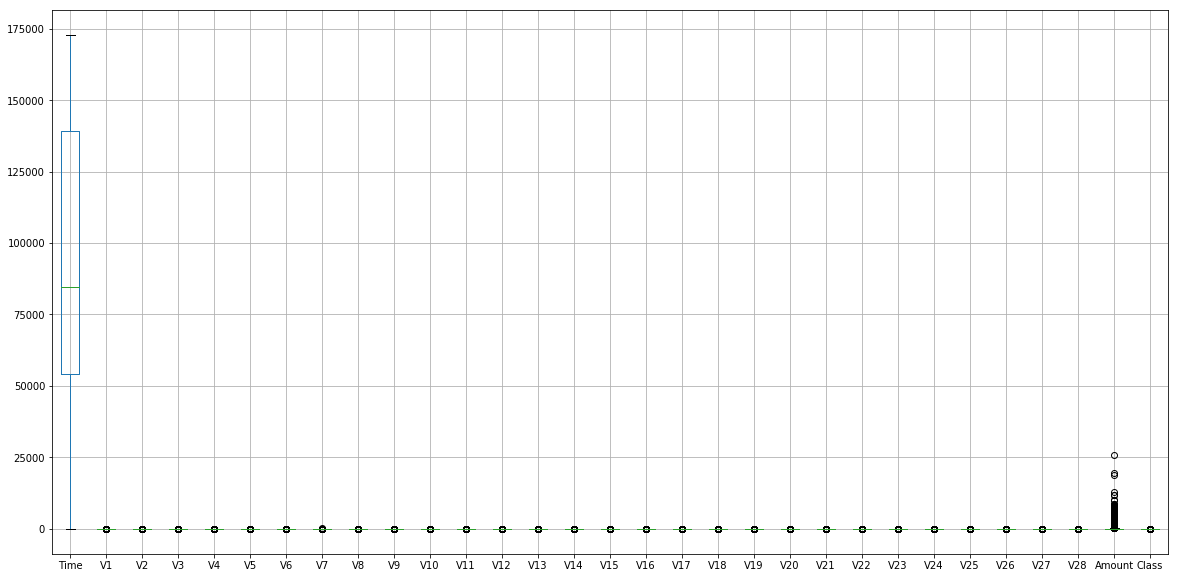

In [8]:
df.boxplot(figsize=(20, 10))
plt.show()

Dropping "Time", "Amount", and "Class", we can observer the distribution with greater detail. Here not all columns are centered around the same point (0 in this case)

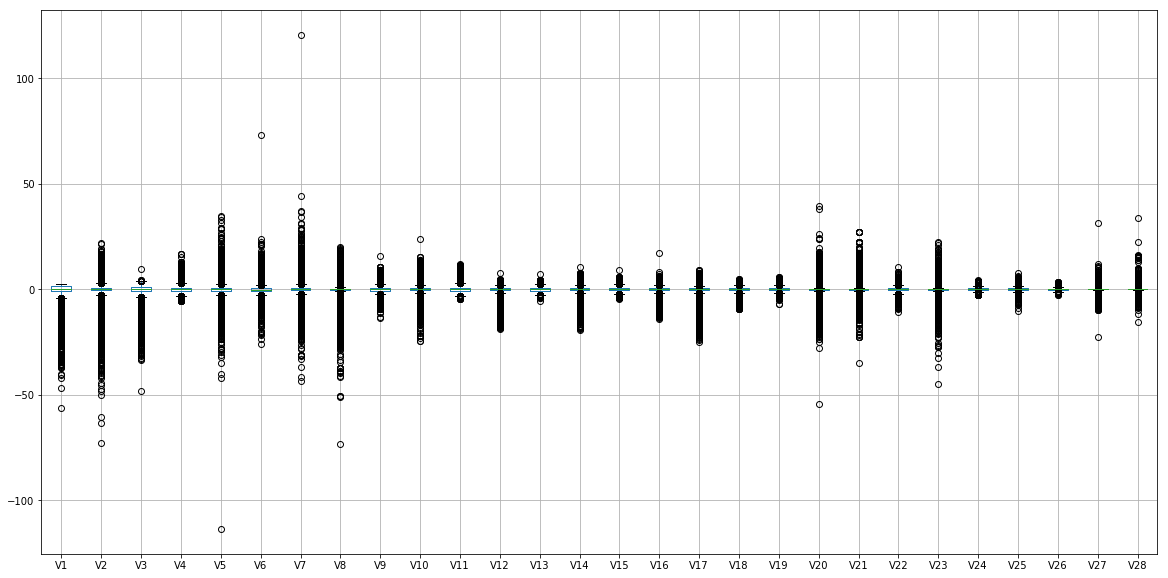

In [38]:
df1 = df.drop(['Time', 'Amount', 'Class'], axis=1)
df1.boxplot(figsize=(20, 10))
plt.show()


### Data Preparation
Before attempting to prepare the data, we would like to inspect distribution of fraud/not-fraud values for class. We know from last two code snippets that **99.8** percent of our transactions are legitimate, so it is crucial to randomize distribution of Class==1 within the dataset, so we do not end up with a lumpy concentration of most of Class==1 in a segment of dataset 

To randomize distribution of Class==1, we shuffle the data in the dataset.

There are three issues with Class==1 being concentrated near one another:
1. We might learn sequential noise
2. We might unlearn what we have learned as we iterate down in the dataset.
3. The dataset includes both training and validation sets and we need to split the data. with a distribution that is not normal and smooth, we might end up with most or all of Class==1 in training or validation.



### Splitting the data to data and label
Next, we would need to prepare the data through the following steps.
1.	Convert tabular data to a numpy vector, so that we can manipulate the data easier.
2.	Split the data to data and label, but moving the "Class" or indeed the last column of the numpy array to a new array.

In [39]:
#Converting Data Into Numpy

raw_data = df.as_matrix()

#Shuffling the data and randomizing the distrbution of the data
#I have performed to shuffles and experimented with different seeds until the distribution 
#of Class==1 became acceptably smooth according to the graph below.

np.random.seed(123)
np.random.shuffle(raw_data)
np.random.seed(499)
np.random.shuffle(raw_data)


label = raw_data[:, -1] #Taking last column of the data and creating a lanel vector
data = raw_data[:, :-1] # Taking the remains of th da

print("shape before split: {}; label_shape = {}; data_shape= {}".format(raw_data.shape, label.shape, data.shape))

shape before split: (284807, 31); label_shape = (284807,); data_shape= (284807, 30)


From previous snippet we see that the originl dataset includes 31 dimensional rows and now we have two vectors, the data vector with each row having a dimension of 30 and label is just a scalar.

### Plotting distribution of Class==1 
Next we would like to be sure that Class==1 records are distributed evenly within the dataset before we attempt to split the data to training and validation.

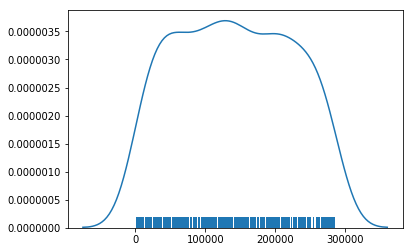

In [40]:
# There are very few fraudulant transactions in the dataset, so I am putting their indexes in an array
# to plot and ensure they are evenly distributed, so when I split the dataset into test and training 
# I don't end up with a dispropostionate distribution
t = []
for i in range(len(label)):
    if label[i] == 1:
        t.append(i)

sns.distplot(t, kde=True, rug=True, hist=False)
plt.show()

The plot above shows is the distribution of Class==1. the blue bar in the bottom (rug==True) shows us that Class==1 is evenly distributed within the range of the data [0..284807]
From the plot above we can observe that 

### Splitting the dataset to train and validation
Now that we are in posession of a good dataset, we cam proceed to split the data into training and validation sets. Here I have done a 70-30 split, you can choose whatever rate you find appropriage.

In [41]:
#Splitting data into validation and training and breaking dataset into data and label

#70%-30% training to validation
train_size = int(data.shape[0]*0.7)

#training data and associated labels
train_data  = data[:train_size, :]
val_data = data[train_size:, :]

#validation data and associated labels
train_label = label[:train_size]
val_label = label[train_size:]


print("training data shape= {}; training label shape = {} \nValidation data shape= {}; validation label shape = {}".format(train_data.shape, 
                                                                        train_label.shape,
                                                                        val_data.shape,
                                                                        val_label.shape))

training data shape= (199364, 30); training label shape = (199364,) 
Validation data shape= (85443, 30); validation label shape = (85443,)


### Saving data for later use
Here I strongly recommend to save the resulting data into files and uploading them to S3. This is a toy dataset and is quickly processed. In real-life pre-processing of the data could take a long time. I remember once I did pre-process a language corpus into vectors and did not save them. I had to later restart my notebooks server and lost all the value in notebook memory. This was 6 hours of wait time.
The saving and uploading are performed in two separate steps:

1. Saving the vectors, suing numpy.save, which saves the prepared vectors as npy objects. I have set `pickle=True` to use pickle serialization.
2. Uploading the data from local (notebook server) to S3. I am using sgemaker.Session object, so that the upload would be authorized to my S3 bucket. Output of sagemaker.upload_data indicates where the files are located. You can check your S3 bucket to ensure the upload is perfomed fully using

In [44]:
#Saving arrays for later use
np.save(local_pickel_root + 'train/train_data.npy', train_data, allow_pickle=True)
np.save(local_pickel_root + 'train/train_label.npy', train_label, allow_pickle=True)
np.save(local_pickel_root + 'test/val_data.npy', val_data, allow_pickle=True)
np.save(local_pickel_root + 'test/val_label.npy', val_label, allow_pickle=True)

!ls -R data/processed/visa-kaggle/data/


data/processed/visa-kaggle/data/:
recordio-pb-data  test	train

data/processed/visa-kaggle/data/test:
val_data.npy  val_label.npy

data/processed/visa-kaggle/data/train:
train_data.npy	train_label.npy


# Part2 - SageMaker Pipeline
## Upload your data onto S3
This could have been done outside of sagemaker as well. 

In [54]:
#Uploading the data.
'''
path is the local path on your notbooks instance
bucket is your bucket name
key_prefix is your folder structure inside you S3 bucket
'''
S3loc = sagemaker_session.upload_data(path=local_pickel_root, bucket=bucket, key_prefix='visa-kaggle/data')
print(S3loc)
!aws s3 ls cyrusmv-sagemaker-demos/visa-kaggle/data/ --recursive #use the output from your own S3loc

s3://cyrusmv-sagemaker-demos/visa-kaggle/data
2018-01-04 12:19:10          0 visa-kaggle/data/
2018-02-13 14:08:16        908 visa-kaggle/data/output/linear-learner-2018-02-13-13-57-11-769/output/model.tar.gz
2018-02-13 14:08:33        909 visa-kaggle/data/output/linear-learner-2018-02-13-13-57-48-247/output/model.tar.gz
2018-02-13 16:15:30   33493152 visa-kaggle/data/recordio-pb-data
2018-02-13 16:15:32   20506400 visa-kaggle/data/test/val_data.npy
2018-02-13 16:15:32     683624 visa-kaggle/data/test/val_label.npy
2018-02-13 16:15:31   47847440 visa-kaggle/data/train/train_data.npy
2018-02-13 16:15:31    1594992 visa-kaggle/data/train/train_label.npy


### Loading Data into Vectors
We will need to have the train and validation data to be loaded into numpy vectors before using them. I am loading the vector from the files I have locally recorded and not S3

In [50]:
train_data = np.load(local_pickel_root + 'train/train_data.npy')
train_label = np.load(local_pickel_root + 'train/train_label.npy')

val_data = np.load(local_pickel_root + 'test/val_data.npy')
val_label = np.load(local_pickel_root + 'test/val_label.npy')

print("training data shape= {}; training label shape = {} \nValidation data shape= {}; validation label shape = {}".format(train_data.shape, 
                                                                        train_label.shape,
                                                                        val_data.shape,
                                                                        val_label.shape))
train_set = (train_data, train_label)
test_set = (val_data, val_label)


training data shape= (199364, 30); training label shape = (199364,) 
Validation data shape= (85443, 30); validation label shape = (85443,)


### Data Conversion
Amazon Algorithms support csv and recordio/protobuf. recordio is faster than CSV and specially in algorithms that deal with sparse matrices.
In the below snippet I am using sagemaker.amazon.core library in order to convert my numpy arrays into protobuf recordIO.

In [51]:
vectors = np.array([t.tolist() for t in train_set[0]]).astype('float32')
labels = np.array([t.tolist() for t in train_set[1]]).astype('float32')

buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, vectors, labels)
buf.seek(0)

0

### Upload training data
Now that we've created our recordIO-wrapped protobuf, we'll need to upload it to S3, so that Amazon SageMaker training can use it.

In [52]:
key = 'recordio-pb-data'
boto3.resource('s3').Bucket(bucket).Object(os.path.join(dist, key)).upload_fileobj(buf)
s3_train_data = 's3://{}/{}{}'.format(bucket, dist, key)
print('uploaded training data location: {}'.format(s3_train_data))

uploaded training data location: s3://cyrusmv-sagemaker-demos/visa-kaggle/data/recordio-pb-data


Let's also setup an output S3 location for the model artifact to be uploaded to after training in complete.

In [53]:
output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('training artifacts will be uploaded to: {}'.format(output_location))

training artifacts will be uploaded to: s3://cyrusmv-sagemaker-demos/visa-kaggle/original.csv/output


### End of Data Preparation Phase
At this point we have a set of npy training and validation files in S3 and no longer need the local data. This tutorial up to here can be split into a separate notebook. In fact I strongly recommend that you should do this. Next, we are going to train LinearLearnier model with the Visa dataset; but before that, let me get a little bit deeper into SageMaker and Amazon Algorithms.

## SageMaker Proces - Training
Before diving into the code, let us get a little bit under the hood of SageMaker and see how it works. SageMaker python SDK has a few core Classes. The most important class hierarchy for training jobs is the Estimator class.

The base class, EstimatorBase, has a method, called ```python fit()```. All classes that are derived from EstimatorBase implement ```python fit()```.

Calling ```python fit()``` results in creating a training job, spinning up a training cluster, and training the model. Once the training is complete, the trained model artefacts will be saved in S3 and training cluster will be torn down.

### Estimator Class Hierarchy
Ignoring Frameworks and other built-in algorithm we can see that EstimatorBase branches into two sections, general Estimator, used for calling dockerized models, and FrameWork from which Estimators class for using frameworks such as MXNet and TensorFlow are derived.
![EstimatorHierarchy](https://github.com/cyrusmvahid/sagemaker-demos/raw/master/docs/images/classes_est_base.png)

Training a model in SageMaker consists of creating an Estimator object, setting hyperparameters, and calling ```python fit()```. Later we review some of the more important hyperparameters.

```python
linear = sagemaker.estimator.Estimator(containers[boto3.Session().region_name],
                                       role, #S3 role, so the notebook can read the data and upload the model
                                       train_instance_count=1, #number of instances for training
                                       train_instance_type='ml.p2.xlarge', # type of training instance
                                       output_path=output_location, #s3 location for uploading trained mdoel
                                       sagemaker_session=sess)
linear.set_hyperparameters(feature_dim=30, #dataset has 30 columns (features)
                           predictor_type='binary_classifier', # for regression set to regressor
                           mini_batch_size=200)

linear.fit({'train': s3_train_data})                                
                                    
```

SageMaker python SDK code can be found in [github](https://github.com/aws/sagemaker-python-sdk). Exploring the code, you can find another alternative to calling Estimator and passing your model image to it. in sagemaker-python-sdk/src/sagemaker/amazon/ you will find a different class hierarchy in which a new class, AmazonAlgorithmsEstimatorBase is derived directly from EstimatorBase. Each of the algorithms implements AmazonAlgorithmsEstimatorBase. For instance, LinearLearner is a specific estimator based on this new superclass. We do not need to use these estimators since general estimator gives us a uniformed way of calling all dockerized, pre-trained algorithms. Below is the class hierarchy for LinearLearner class.

![estimator class](https://github.com/cyrusmvahid/sagemaker-demos/raw/master/docs/images/estimator_linearlearner.png)

## SageMaker Process - Training the model
multiple regions. We follow the following steps
1. define containers dictionary.
2. Create am Estimator object and pass the hyper-parameters as well as the model location to it.
3. run Estimator.fit to begin training the model

In [20]:
containers = {'us-west-2': '174872318107.dkr.ecr.us-west-2.amazonaws.com/linear-learner:latest',
              'us-east-1': '382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner:latest',
              'us-east-2': '404615174143.dkr.ecr.us-east-2.amazonaws.com/linear-learner:latest',
              'eu-west-1': '438346466558.dkr.ecr.eu-west-1.amazonaws.com/linear-learner:latest'}

In [55]:
sess = sagemaker.Session()

linear = sagemaker.estimator.Estimator(containers[boto3.Session().region_name],
                                       role, #S3 role, so the notebook can read the data and upload the model
                                       train_instance_count=1, #number of instances for training
                                       train_instance_type='ml.p2.xlarge', # type of training instance
                                       output_path=output_location, #s3 location for uploading trained mdoel
                                       sagemaker_session=sess)

linear.set_hyperparameters(feature_dim=30, #dataset has 30 columns (features)
                           predictor_type='binary_classifier', # we predict a binary value. it could have been regressor
                           mini_batch_size=200)

linear.fit({'train': s3_train_data})

INFO:sagemaker:Creating training-job with name: linear-learner-2018-02-13-16-23-45-273


............................................................................
Docker entrypoint called with argument(s): train
[02/13/2018 16:29:57 INFO 140471961589568] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'epochs': u'10', u'init_bias': u'0.0', u'lr_scheduler_factor': u'0.99', u'num_calibration_samples': u'10000000', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'bias_lr_mult': u'10', u'lr_scheduler_step': u'100', u'init_method': u'uniform', u'init_sigma': u'0.01', u'lr_scheduler_minimum_lr': u'0.00001', u'target_recall': u'0.8', u'num_models': u'32', u'momentum': u'0.0', u'unbias_label': u'auto', u'wd': u'0.0', u'optimizer': u'adam', u'learning_rate': u'auto', u'_kvstore': u'auto', u'normalize_data': u'true', u'binary_classifier_model_selection_criteria': u'accuracy', u'use_lr_scheduler': u'true', u'target_precision': u'0.8', u'force_dense': u'true', u

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "max": 0.00566765322847419, "sum": 0.00566765322847419, "min": 0.00566765322847419}, "validation_binary_classification_cross_entropy": {"count": 1, "max": -Infinity, "sum": NaN, "min": Infinity}}, "EndTime": 1518539481.715348, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 2}, "StartTime": 1518539481.715245}

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "max": 0.004825514521464765, "sum": 0.004825514521464765, "min": 0.004825514521464765}, "validation_binary_classification_cross_entropy": {"count": 1, "max": -Infinity, "sum": NaN, "min": Infinity}}, "EndTime": 1518539481.715447, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 2}, "StartTime": 1518539481.715424}

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, 

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "max": 0.0049351280024013365, "sum": 0.0049351280024013365, "min": 0.0049351280024013365}, "validation_binary_classification_cross_entropy": {"count": 1, "max": -Infinity, "sum": NaN, "min": Infinity}}, "EndTime": 1518539521.853717, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 3}, "StartTime": 1518539521.853617}

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "max": 0.004272033306152885, "sum": 0.004272033306152885, "min": 0.004272033306152885}, "validation_binary_classification_cross_entropy": {"count": 1, "max": -Infinity, "sum": NaN, "min": Infinity}}, "EndTime": 1518539521.853804, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 3}, "StartTime": 1518539521.853787}

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "max": 0.0047066798815167095, "sum": 0.0047066798815167095, "min": 0.0047066798815167095}, "validation_binary_classification_cross_entropy": {"count": 1, "max": -Infinity, "sum": NaN, "min": Infinity}}, "EndTime": 1518539562.149102, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 4}, "StartTime": 1518539562.148997}

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "max": 0.004219565435413675, "sum": 0.004219565435413675, "min": 0.004219565435413675}, "validation_binary_classification_cross_entropy": {"count": 1, "max": -Infinity, "sum": NaN, "min": Infinity}}, "EndTime": 1518539562.149195, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 4}, "StartTime": 1518539562.149178}

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "max": 0.004611711336905698, "sum": 0.004611711336905698, "min": 0.004611711336905698}, "validation_binary_classification_cross_entropy": {"count": 1, "max": -Infinity, "sum": NaN, "min": Infinity}}, "EndTime": 1518539602.438909, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 5}, "StartTime": 1518539602.438813}

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "max": 0.0041053236841811355, "sum": 0.0041053236841811355, "min": 0.0041053236841811355}, "validation_binary_classification_cross_entropy": {"count": 1, "max": -Infinity, "sum": NaN, "min": Infinity}}, "EndTime": 1518539602.438997, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 5}, "StartTime": 1518539602.43898}

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count"

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "max": 0.004567882297149145, "sum": 0.004567882297149145, "min": 0.004567882297149145}, "validation_binary_classification_cross_entropy": {"count": 1, "max": -Infinity, "sum": NaN, "min": Infinity}}, "EndTime": 1518539642.867526, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 6}, "StartTime": 1518539642.867337}

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "max": 0.004108989604124163, "sum": 0.004108989604124163, "min": 0.004108989604124163}, "validation_binary_classification_cross_entropy": {"count": 1, "max": -Infinity, "sum": NaN, "min": Infinity}}, "EndTime": 1518539642.867653, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 6}, "StartTime": 1518539642.86763}

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "max": 0.004545868605704432, "sum": 0.004545868605704432, "min": 0.004545868605704432}, "validation_binary_classification_cross_entropy": {"count": 1, "max": -Infinity, "sum": NaN, "min": Infinity}}, "EndTime": 1518539683.320407, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 7}, "StartTime": 1518539683.32026}

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "max": 0.00404934419876331, "sum": 0.00404934419876331, "min": 0.00404934419876331}, "validation_binary_classification_cross_entropy": {"count": 1, "max": -Infinity, "sum": NaN, "min": Infinity}}, "EndTime": 1518539683.320526, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 7}, "StartTime": 1518539683.320504}

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "max": 0.004526677778192672, "sum": 0.004526677778192672, "min": 0.004526677778192672}, "validation_binary_classification_cross_entropy": {"count": 1, "max": -Infinity, "sum": NaN, "min": Infinity}}, "EndTime": 1518539724.920011, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 8}, "StartTime": 1518539724.919915}

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "max": 0.0040510251828241185, "sum": 0.0040510251828241185, "min": 0.0040510251828241185}, "validation_binary_classification_cross_entropy": {"count": 1, "max": -Infinity, "sum": NaN, "min": Infinity}}, "EndTime": 1518539724.92011, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 8}, "StartTime": 1518539724.920087}

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count"

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "max": 0.004505496464639783, "sum": 0.004505496464639783, "min": 0.004505496464639783}, "validation_binary_classification_cross_entropy": {"count": 1, "max": -Infinity, "sum": NaN, "min": Infinity}}, "EndTime": 1518539765.396218, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 9}, "StartTime": 1518539765.396114}

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "max": 0.004010293117862748, "sum": 0.004010293117862748, "min": 0.004010293117862748}, "validation_binary_classification_cross_entropy": {"count": 1, "max": -Infinity, "sum": NaN, "min": Infinity}}, "EndTime": 1518539765.396306, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 9}, "StartTime": 1518539765.396289}

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "max": 0.004484349691110802, "sum": 0.004484349691110802, "min": 0.004484349691110802}, "validation_binary_classification_cross_entropy": {"count": 1, "max": -Infinity, "sum": NaN, "min": Infinity}}, "EndTime": 1518539805.854036, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 10}, "StartTime": 1518539805.853937}

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "max": 0.00402259058017942, "sum": 0.00402259058017942, "min": 0.00402259058017942}, "validation_binary_classification_cross_entropy": {"count": 1, "max": -Infinity, "sum": NaN, "min": Infinity}}, "EndTime": 1518539805.854131, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 10}, "StartTime": 1518539805.854108}

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1

#metrics {"Metrics": {"f1": {"count": 1, "max": 0.8033707865168539, "sum": 0.8033707865168539, "min": 0.8033707865168539}, "threshold_for_accuracy": {"count": 1, "max": 0.12957409024238586, "sum": 0.12957409024238586, "min": 0.12957409024238586}, "threshold_for_precision_at_target_recall": {"count": 1, "max": 0.06492825597524643, "sum": 0.06492825597524643, "min": 0.06492825597524643}, "threshold_for_recall_at_target_precision": {"count": 1, "max": 0.08203981071710587, "sum": 0.08203981071710587, "min": 0.08203981071710587}, "recall_at_precision": {"count": 1, "max": 0.7971014492754211, "sum": 0.7971014492754211, "min": 0.7971014492754211}, "precision_at_target_recall": {"count": 1, "max": 0.798270893371816, "sum": 0.798270893371816, "min": 0.798270893371816}, "accuracy": {"count": 1, "max": 0.999332878553801, "sum": 0.999332878553801, "min": 0.999332878553801}, "threshold_for_f1": {"count": 1, "max": 0.038537416607141495, "sum": 0.038537416607141495, "min": 0.038537416607141495}}, "En

===== Job Complete =====


### Monitoring your Training Job
Amazon SageMaker has logs training using Amazon CloudWatch. The logs are located under aws/TrainingJobs
![training logs](https://github.com/cyrusmvahid/sagemaker-demos/blob/master/docs/images/SageMakerLogs.png?raw=true)

Amazon SageMaker also provide a set of Metrics. Metrics include:
- Memory Utilization
- CPU Utilization
- GPU Unitlization
- Disk Utilization
You can use these metrics to size your training cluster accordingly.
![training logs](https://github.com/cyrusmvahid/sagemaker-demos/blob/master/docs/images/SageMakerMetrics.png?raw=true)

## SageMaker Process - Hosting the model
Now that we have a trained and saved model, we can venture into creating endpoints. Amazon SageMaker requires a single line of code in order to created a fully managed and elasticlly scalable endpoint environemnt. 

Amazon SageMaker takes your model file from the S3 bucket and dockerizes it. It also creates an Amazon [ECS (Amazon Elastic Container Service)](https://aws.amazon.com/documentation/ecs/) infrastructre, fronted with an [ELB or ElasticLoadBalncer](https://aws.amazon.com/documentation/elastic-load-balancing/).

The instances are also members of an [Autoscaling Group](https://docs.aws.amazon.com/autoscaling/ec2/userguide/AutoScalingGroup.html), meaning that based on the incoming load the number of docker images and underlying EC2 instances can growand shrink dynamically. 

Model hosting and Deployment is independent of how you develop your models, meaning that you do not need to develop your model within Amazon SageMaker or use Amazon Algorithms in order to host your models in Amazon SageMaker. 

This post is foused on LinearLearning and hosting your models is out of the scope of this blog post. For more information please refer to [Amazon SageMaker doumentation](https://docs.aws.amazon.com/sagemaker/latest/dg/your-algorithms.html)

From the class diaram we delved into previously, we can remember that EstimatorBase implements a method called `deploy()`. All the deployment magic happens through a single call to `Estimator.deploy()`

We pass initial cluster size and instance type to `deploy()`. 
```python
linear_predictor = linear.deploy(initial_instance_count=1, #Initial number of instances. 
                                                           #Autoscaling can increase the number of instances.
                                 instance_type='ml.m4.xlarge') # instance type
```

Executing `deploy()` calls `create_model()`. `create_model()` is an abstract method of EstimatorBase and is implemented by its sub-classes. `create_model()` in turn returns a Model object. calling  `deploy()` returns a RealTimePredictor class, that can be in fact deployed to the live environement.

### Model Class Hierarchy
![Model](https://github.com/cyrusmvahid/sagemaker-demos/blob/master/docs/images/classes_model_base.png?raw=true)


### Predictor Class 
![predictor](https://github.com/cyrusmvahid/sagemaker-demos/blob/master/docs/images/classes_predictor.png?raw=true)


In [25]:
linear_predictor = linear.deploy(initial_instance_count=1, #Initial number of instances. 
                                                           #Autoscaling can increase the number of instances.
                                 instance_type='ml.m4.xlarge') # instance type

INFO:sagemaker:Creating model with name: linear-learner-2018-02-13-15-19-04-112
INFO:sagemaker:Creating endpoint with name linear-learner-2018-02-13-13-48-23-462


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------!

In [57]:
type(linear_predictor)

sagemaker.predictor.RealTimePredictor

## SageMaker Process - Prediction
We the print in the previous snippet we can see that `Estimator.deploy()` eventually returns a `sagemaker.predictor.RealTimePredictor` object. `sagemaker.predictor.RealTimePredictor` implements a method called `predict()`, which is used to make live predictions.

Predictors in sagemaker accept csv and json. In this case we use json serialization.

In [58]:
linear_predictor.content_type = 'text/csv'
linear_predictor.serializer = csv_serializer
linear_predictor.deserializer = json_deserializer

Since Fraudulant records are rate, I have created an array of all records in validation set with *"Class==1"* in order to test model accuracy by testing the predictor endpoint on ranges that in fact includes fraudulant transactions.

You can observe that record number 516 is correctly predicted to be a fraud when we would run prediction in range of 515-519

*
{'predictions': [{'score': 0.0006907652714289725, 'predicted_label': 0.0}, **{'score': 0.9957004189491272, 'predicted_label': 1.0}**, {'score': 0.0006745134014636278, 'predicted_label': 0.0}, {'score': 0.0006603851797990501, 'predicted_label': 0.0}]}
*


In [59]:
#since score==1 is very rare we want to make sure we can correctly predict fradulant transaction. 
#First we print a lost of all labels where score == 1, then then run a prediction
t = []
for i in range(len(train_label)):
    if train_label[i] == 1:
        t.append(i)
        
print(t)

print('\n')
print(linear_predictor.predict(train_set[0][515:519]))


[516, 765, 867, 2636, 2704, 3360, 3583, 4111, 4482, 5115, 6463, 7810, 8008, 8420, 9171, 9178, 10236, 10591, 10604, 10701, 11363, 13516, 14479, 15167, 15396, 15949, 16334, 16348, 16982, 17309, 17698, 18155, 19023, 19048, 19116, 20236, 20382, 20701, 21038, 21080, 21509, 22228, 24887, 25425, 25840, 26055, 26797, 27138, 27982, 28853, 30106, 30733, 31027, 31317, 31353, 32757, 33018, 33285, 33710, 34422, 34926, 35447, 35595, 35699, 35700, 35922, 37207, 39095, 39165, 39623, 39954, 40098, 40486, 41384, 41871, 42159, 43274, 43573, 43641, 43798, 43949, 44281, 44954, 45959, 46102, 48351, 48763, 49023, 49041, 49576, 52158, 52165, 53136, 54002, 54994, 57241, 57242, 58254, 58297, 58298, 58707, 59283, 59350, 59791, 59795, 59966, 59981, 60137, 60226, 60260, 60705, 62107, 62426, 64015, 64309, 64645, 65028, 66338, 68281, 69096, 69159, 69280, 69344, 69487, 69530, 71003, 71055, 71580, 72302, 73057, 73358, 73389, 73644, 75015, 75384, 77773, 77821, 77843, 78179, 79448, 79479, 80184, 82184, 82484, 83329, 852

In [60]:
non_zero = np.count_nonzero(test_set[1])
zero = len(test_set[1]) - non_zero
print("validation set includes: {} non zero and {} items woth value zero".format(non_zero, zero))

validation set includes: 147 non zero and 85296 items woth value zero


In [61]:
predictions = []
for array in np.array_split(test_set[0], 100):
    result = linear_predictor.predict(array)
    predictions += [r['predicted_label'] for r in result['predictions']]

predictions = np.array(predictions)

In [63]:
import pandas as pd

pd.crosstab(test_set[1], predictions, rownames=['actuals'], colnames=['predictions'])

predictions,0.0,1.0
actuals,,
0.0,85265,31
1.0,29,118


### Analyzing the Results
The confusion matrix above indicates that:
- of 147 fraudulent cases, we detected 118 correctly
- 31 times a non-fraudulent transaction has been flagged as fraud from a total of 85443 transactions.

We can observe that (85443 – (29 + 31)) = 85383 out of 85443 records or 99.93% of the predictions are accurate. The model produces a superb precision, but how about recall? Our rate of predicting fraudulent transactions are 118/147 or approximately 80%. 

We can optimize the model to balance between recall and precision. In part 3, Excel in tuning models using Amazon LinearLearner Algorithm, I will attempt to tune the model to prioritize recall over accuracy and report the results. The data set has how dimensions and we are using HPO, so we might not be able to improve the results in any meaningful way. It is worth experimenting though.

The model performance is based on default parameters that are located in training instances in `/opt/ml/input/config/hyperparameters.json`

The default parameters are:

u'epochs': u'10', u'init_bias': u'0.0', u'lr_scheduler_factor': u'0.99', **u'num_calibration_samples': u'10000000'**, u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'bias_lr_mult': u'10', u'lr_scheduler_step': u'100', u'init_method': u'uniform', u'init_sigma': u'0.01', u'lr_scheduler_minimum_lr': u'0.00001', **u'target_recall': u'0.8'**, **u'num_models': u'32'**, u'momentum': u'0.0', u'unbias_label': u'auto', u'wd': u'0.0', u'optimizer': u'adam', u'learning_rate': u'auto', u'_kvstore': u'auto', **u'normalize_data': u'true'**, **u'binary_classifier_model_selection_criteria': u'accuracy'**, u'use_lr_scheduler': u'true', **u'target_precision': u'0.8'**, u'force_dense': u'true', u'unbias_data': u'auto', u'init_scale': u'0.07', u'bias_wd_mult': u'0', u'mini_batch_size': u'1000', u'beta_1': u'0.9', u'loss': u'auto', u'beta_2': u'0.999', u'normalize_label': u'auto', u'_num_gpus': u'auto', u'_data_format': u'record', u'positive_example_weight_mult': u'1.0', u'l1': u'0.0'}le_weight_mult': u'1.0', u'l1': u'0.0'}



A detailed description of the parameters can be found [in the Amazon SageMaker documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/ll_hyperparameters.html)

The most likely parameters that could be useful for improving recall are:
- binary_classifier_model_selection_criteria
- target_recall
- target_precision
- num_calibration_samples
- num_models


### Monitor the live environment
A key feature of monitoring SageMaker Endpoints is that you do not monitor infrastructure, instead, you are monitoring your models even if they might be deployed on multiple machines. This gives you a holistic view of your model performance.

Amazon Cloud Watch Logs includes /aws/sagemaker/Endpoints per endpoint you create. You can use logs to monitor your model logs including all the calls to your endpoints.

![endpoint_logs](https://github.com/cyrusmvahid/sagemaker-demos/blob/master/docs/images/EndpointLogs.png?raw=true)
For a graphical view of your metrics you can use Amazon CloutWatch Metrics. You can monitor your model metrics such as:
- GPU Utilization
- CPU Utilization
- Latency
- Memory Utilization

for more infomation please refer to [SageMaker documentation](!https://docs.aws.amazon.com/sagemaker/latest/dg/monitoring-overview.html)

the following screenshot is the results of several thousands of endpoint calls I performed on my linear learner.

![monitoring](https://github.com/cyrusmvahid/sagemaker-demos/blob/master/docs/images/EndpointMetricsGraph.png?raw=true)

# (optional) Delete the endpoint
f you're ready to be done with this notebook, please run the delete_endpoint line in the cell below. This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

In [ ]:
linear.delete_endpoint()